In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
import numpy as np
from    missingno import matrix
import scipy.stats as stats
from pathlib import Path
import fnmatch
from collections import defaultdict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import f1_score
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import optimizers
from keras.optimizers import Adam
from time import time
from timeit import default_timer as timer

# For Genetic Algorithm
import random
from random import shuffle, choice, sample, random, randint, uniform
from operator import attrgetter
from copy import deepcopy

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [4]:
# Splitting the dataset
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [6]:
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [7]:
def get_fitness(individual):

    X_train_1, y_train_1 = [], []
    
    for i in range(y_train.shape[0] - (individual[0]-1)):
        X_train_1.append(train_scaled.iloc[i:i+individual[0]].values)
        y_train_1.append(y_train.iloc[i + (individual[0]-1)])
    X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
    print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

    X_test_1, y_test_1 = [], []
    for i in range(y_test.shape[0] - (individual[0]-1)):
      X_test_1.append(test_scaled.iloc[i:i+individual[0]].values)
      y_test_1.append(y_test.iloc[i + (individual[0]-1)])
    X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
    print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

    # GRU model with 2 stucked GRU layers with activation function relu

    model = Sequential()
    model.add(GRU(individual[1], activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
    model.add(GRU(individual[1], activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())

    # Define a learning rate decay method:
    lr_decay = ReduceLROnPlateau(monitor='loss', 
                            patience=1, verbose=1, 
                            factor=0.5, min_lr=1e-8)
    # Define Early Stopping:
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                          patience=30, verbose=1, mode='auto',
                          baseline=0, restore_best_weights=True)
    

    History = model.fit(X_train_1, y_train_1,
                    epochs=individual[2],
                    batch_size=individual[3],
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
        
    # get the lowest validation loss of the training epochs
    fitness = History.history['val_loss'][-1]
    print('Fitness:', fitness)

    return fitness

In [8]:
# Define hyperparameters to be optimized
hyperparameters = {
    'timestep': np.arange(1, 2), 
    'num_units': np.arange(10, 50), 
    'num_epochs': np.arange(1, 2), 
    'batch_size': np.arange(10, 100), 
}

# Define the population size and number of generations
POPULATION_SIZE = 10
NUM_GENERATIONS = 5

# Define the mutation and crossover probabilities
mu_p = 0.3
co_p = 0.8

# Define the initial population
population = []
for i in range(POPULATION_SIZE):
    individual = []
    for param in hyperparameters.values():
        individual.append(choice(param))
    population.append(individual)

best_fitness_list = []

# Evolution loop
for generation in range(NUM_GENERATIONS):
    print("\n\nGeneration "+str(generation+1))
    # Calculate the fitness scores for each individual in the population
    fitness_scores = []
    for individual in population:
        print(individual)
        fitness_score = get_fitness(individual)
        fitness_scores.append(fitness_score)

    print(fitness_scores)
    val, idx = min((val, idx) for (idx, val) in enumerate(fitness_scores))
    best_model = population[idx]
    print("Best model is {}".format(best_model))
    print("Best model fitness is {}".format(val))
    best_fitness_list.append(val)
    
    # Select the parents for the next generation using tournament selection
    parents = []
    for i in range(POPULATION_SIZE):
        tournament = sample(range(POPULATION_SIZE), 3) 
        fitness_tournament = [fitness_scores[j] for j in tournament]
        winner = tournament[np.argmin(fitness_tournament)]
        parents.append(population[winner])
    
    # Create the next generation by performing crossover and mutation 
    new_population = []
    for i in range(POPULATION_SIZE):
        parent1, parent2 = sample(parents, 2)
        #print(parents, parent1, parent2)
        child = []
        for j in range(len(parent1)):
            if random() < co_p:
                child.append(parent1[j])
            else:
                child.append(parent2[j])
        if random() < mu_p:
            mutated_param_index = randint(0, len(hyperparameters)-1)
            mutated_param = list(hyperparameters.values())[mutated_param_index]
            child[mutated_param_index] = choice(mutated_param)
        new_population.append(child)
    
    # Replace the old population with the new one
    population = new_population



Generation 1
[1, 11, 1, 41]
Train data dimensions: (164563, 1, 6), (164563, 1)
Test data dimensions: (70527, 1, 6), (70527, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 11)             627       
                                                                 
 gru_1 (GRU)                 (None, 11)                792       
                                                                 
 dense (Dense)               (None, 9)                 108       
                                                                 
Total params: 1,527
Trainable params: 1,527
Non-trainable params: 0
_________________________________________________________________
None
4014/4014 [==============================] - 20s 4ms/step - loss: 0.3322 - accuracy: 0.9030 - val_loss: 0.1880 - val_accuracy: 0.9436 - lr: 0.0010
Fitness: 0.18801741302013397
[1, 18, 

In [12]:
best_fitness_list

[0.10235029458999634,
 0.10280278325080872,
 0.10148102045059204,
 0.09735178202390671,
 0.09870965778827667]

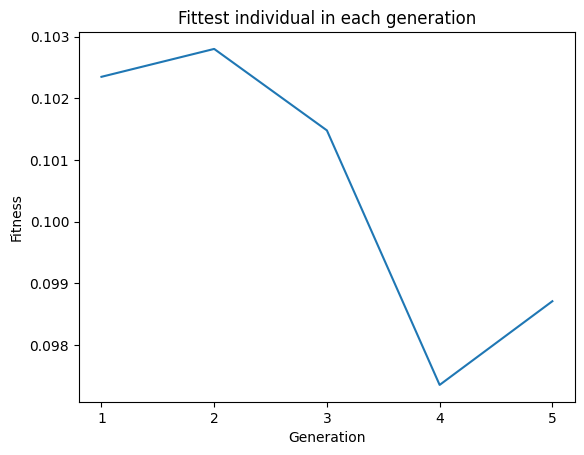

In [14]:
generations = range(1, len(best_fitness_list) + 1)

plt.plot(generations, best_fitness_list)
plt.title('Fittest individual in each generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.xticks(np.arange(1, len(best_fitness_list)+1, step=1))
plt.show()

In [11]:
val, idx = min((val, idx) for (idx, val) in enumerate(best_fitness_list))
best_model = population[idx]
print("Best model is {}".format(best_model))
print("Best model fitness is {}".format(val))

Best model is [1, 47, 1, 14]
Best model fitness is 0.09735178202390671


In [15]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

T = best_model[0]
X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
  X_train_1.append(train_scaled.iloc[i:i+T].values)
  y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
  X_test_1.append(test_scaled.iloc[i:i+T].values)
  y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

# GRU model with 2 stucked GRU layers with activation function relu

model = Sequential()
model.add(GRU(best_model[1], activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(best_model[1], activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                        epochs=40,
                        batch_size=best_model[3],
                        validation_data=(X_test_1, y_test_1),
                        shuffle=True,verbose=1,
                        callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

y_pred = np.argmax(model.predict(X_test_1), axis=-1)

Train data dimensions: (164563, 1, 6), (164563, 1)
Test data dimensions: (70527, 1, 6), (70527, 1)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_100 (GRU)               (None, 1, 47)             7755      
                                                                 
 gru_101 (GRU)               (None, 47)                13536     
                                                                 
 dense_50 (Dense)            (None, 9)                 432       
                                                                 
Total params: 21,723
Trainable params: 21,723
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/40
11755/11755 [==============================] - 54s 4ms/step - loss: 0.1564 - accuracy: 0.9473 - val_loss: 0.1035 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 2/40
11755/11755 [=========================

<Axes: >

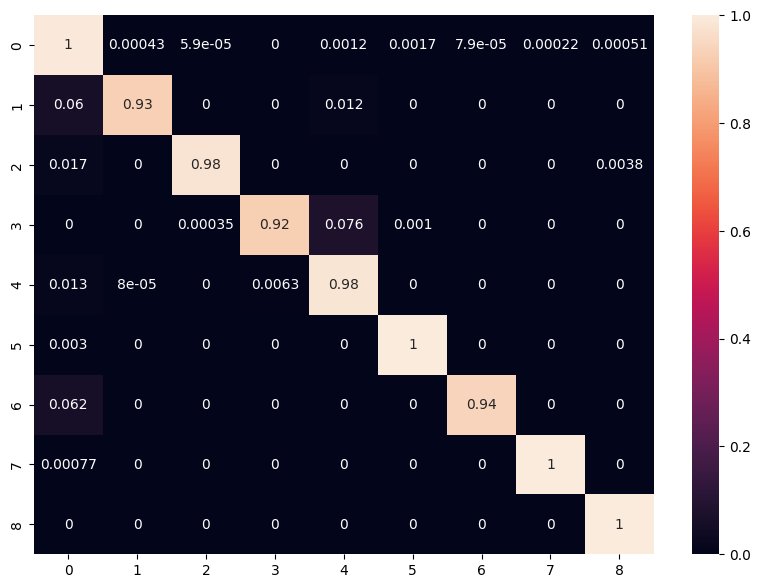

In [16]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

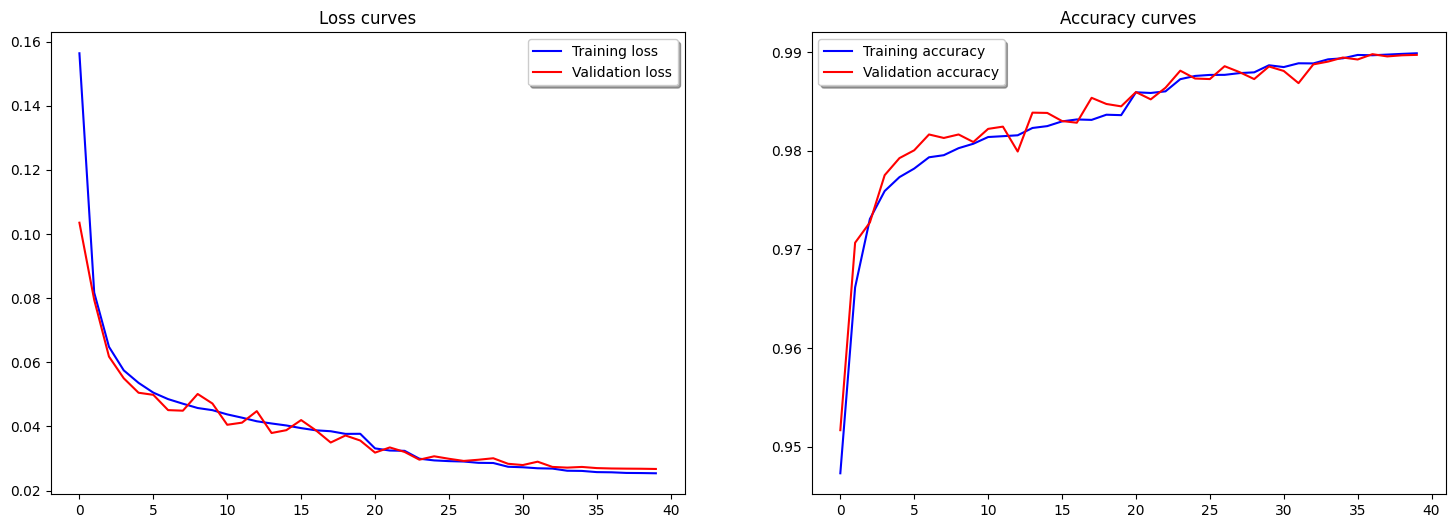

In [17]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [18]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9897202489826591
Confusion Matrix: 
 [[50619    22     3     0    59    87     4    11    26]
 [   25   390     0     0     5     0     0     0     0]
 [    9     0   519     0     0     0     0     0     2]
 [    0     0     1  2636   218     3     0     0     0]
 [  159     1     0    78 12205     0     0     0     0]
 [    5     0     0     0     0  1639     0     0     0]
 [    6     0     0     0     0     0    91     0     0]
 [    1     0     0     0     0     0     0  1292     0]
 [    0     0     0     0     0     0     0     0   411]]
Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     50831
           1       0.94      0.93      0.94       420
           2       0.99      0.98      0.99       530
           3       0.97      0.92      0.95      2858
           4       0.98      0.98      0.98     12443
           5       0.95      1.00      0.97      1644
           6